___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# DBSCAN Project  

## The Data


Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Provide all relevant information about your data set.


Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----

## DBSCAN and Clustering Examples

**COMPLETE THE TASKS IN BOLD BELOW:**

**TASK: Run the following cells to import the data and view the DataFrame.**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../DATA/wholesome_customers_data.csv')

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [10]:
print(df['Channel'].unique())
print(df['Region'].unique())

[2 1]
[3 1 2]


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## EDA

**TASK: Create a scatterplot showing the relation between MILK and GROCERY spending, colored by Channel column.**

<Axes: xlabel='Milk', ylabel='Grocery'>

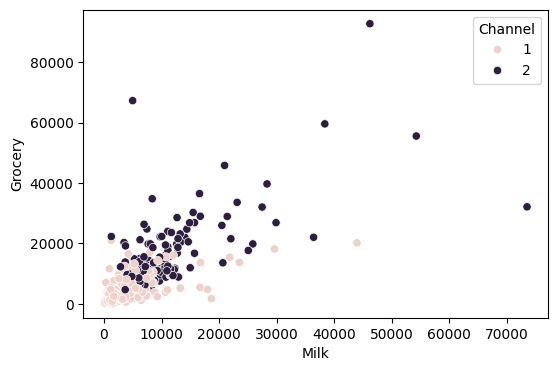

In [20]:
plt.figure(figsize=(6,4))
sns.scatterplot(df,x='Milk',y='Grocery',hue='Channel')

# spend more in milk == spend more in grocery relation

**TASK: Use seaborn to create a histogram of MILK spending, colored by Channel. Can you figure out how to use seaborn to "stack" the channels, instead of have them overlap?**

<Axes: xlabel='Milk', ylabel='Count'>

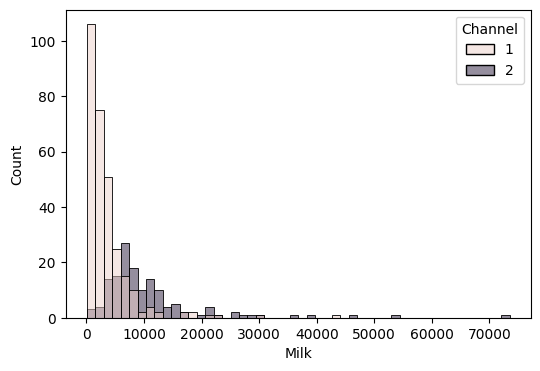

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(df,x='Milk',hue='Channel') # overlaped (multiple='layer' default)

<Axes: xlabel='Milk', ylabel='Count'>

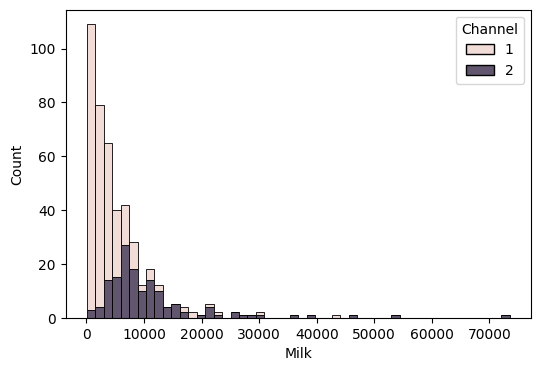

In [24]:
plt.figure(figsize=(6,4))
sns.histplot(df,x='Milk',hue='Channel',multiple='stack') # vs stacked 

**TASK: Create an annotated clustermap of the correlations between spending on different cateogires.**

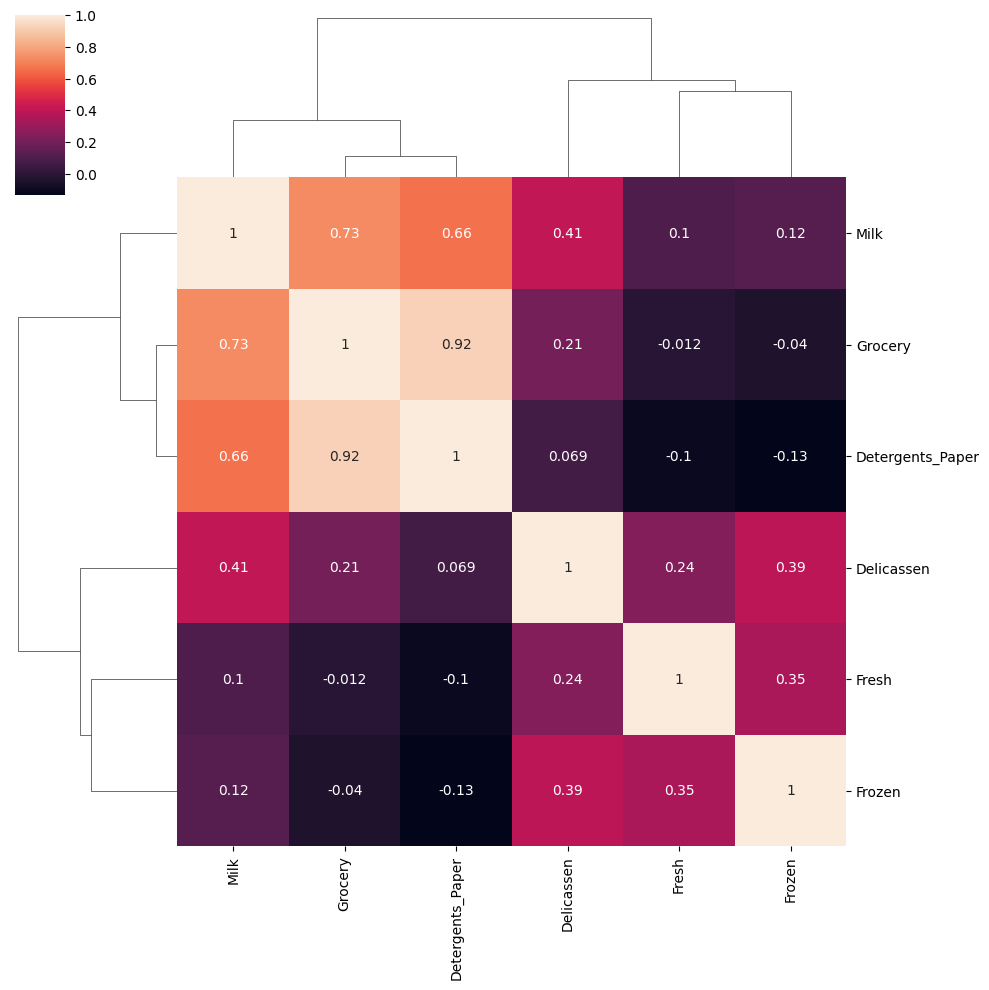

In [37]:
sns.clustermap(df.drop(['Channel','Region'],axis=1).corr(),annot=True)

**TASK: Create a PairPlot of the dataframe, colored by Region.**

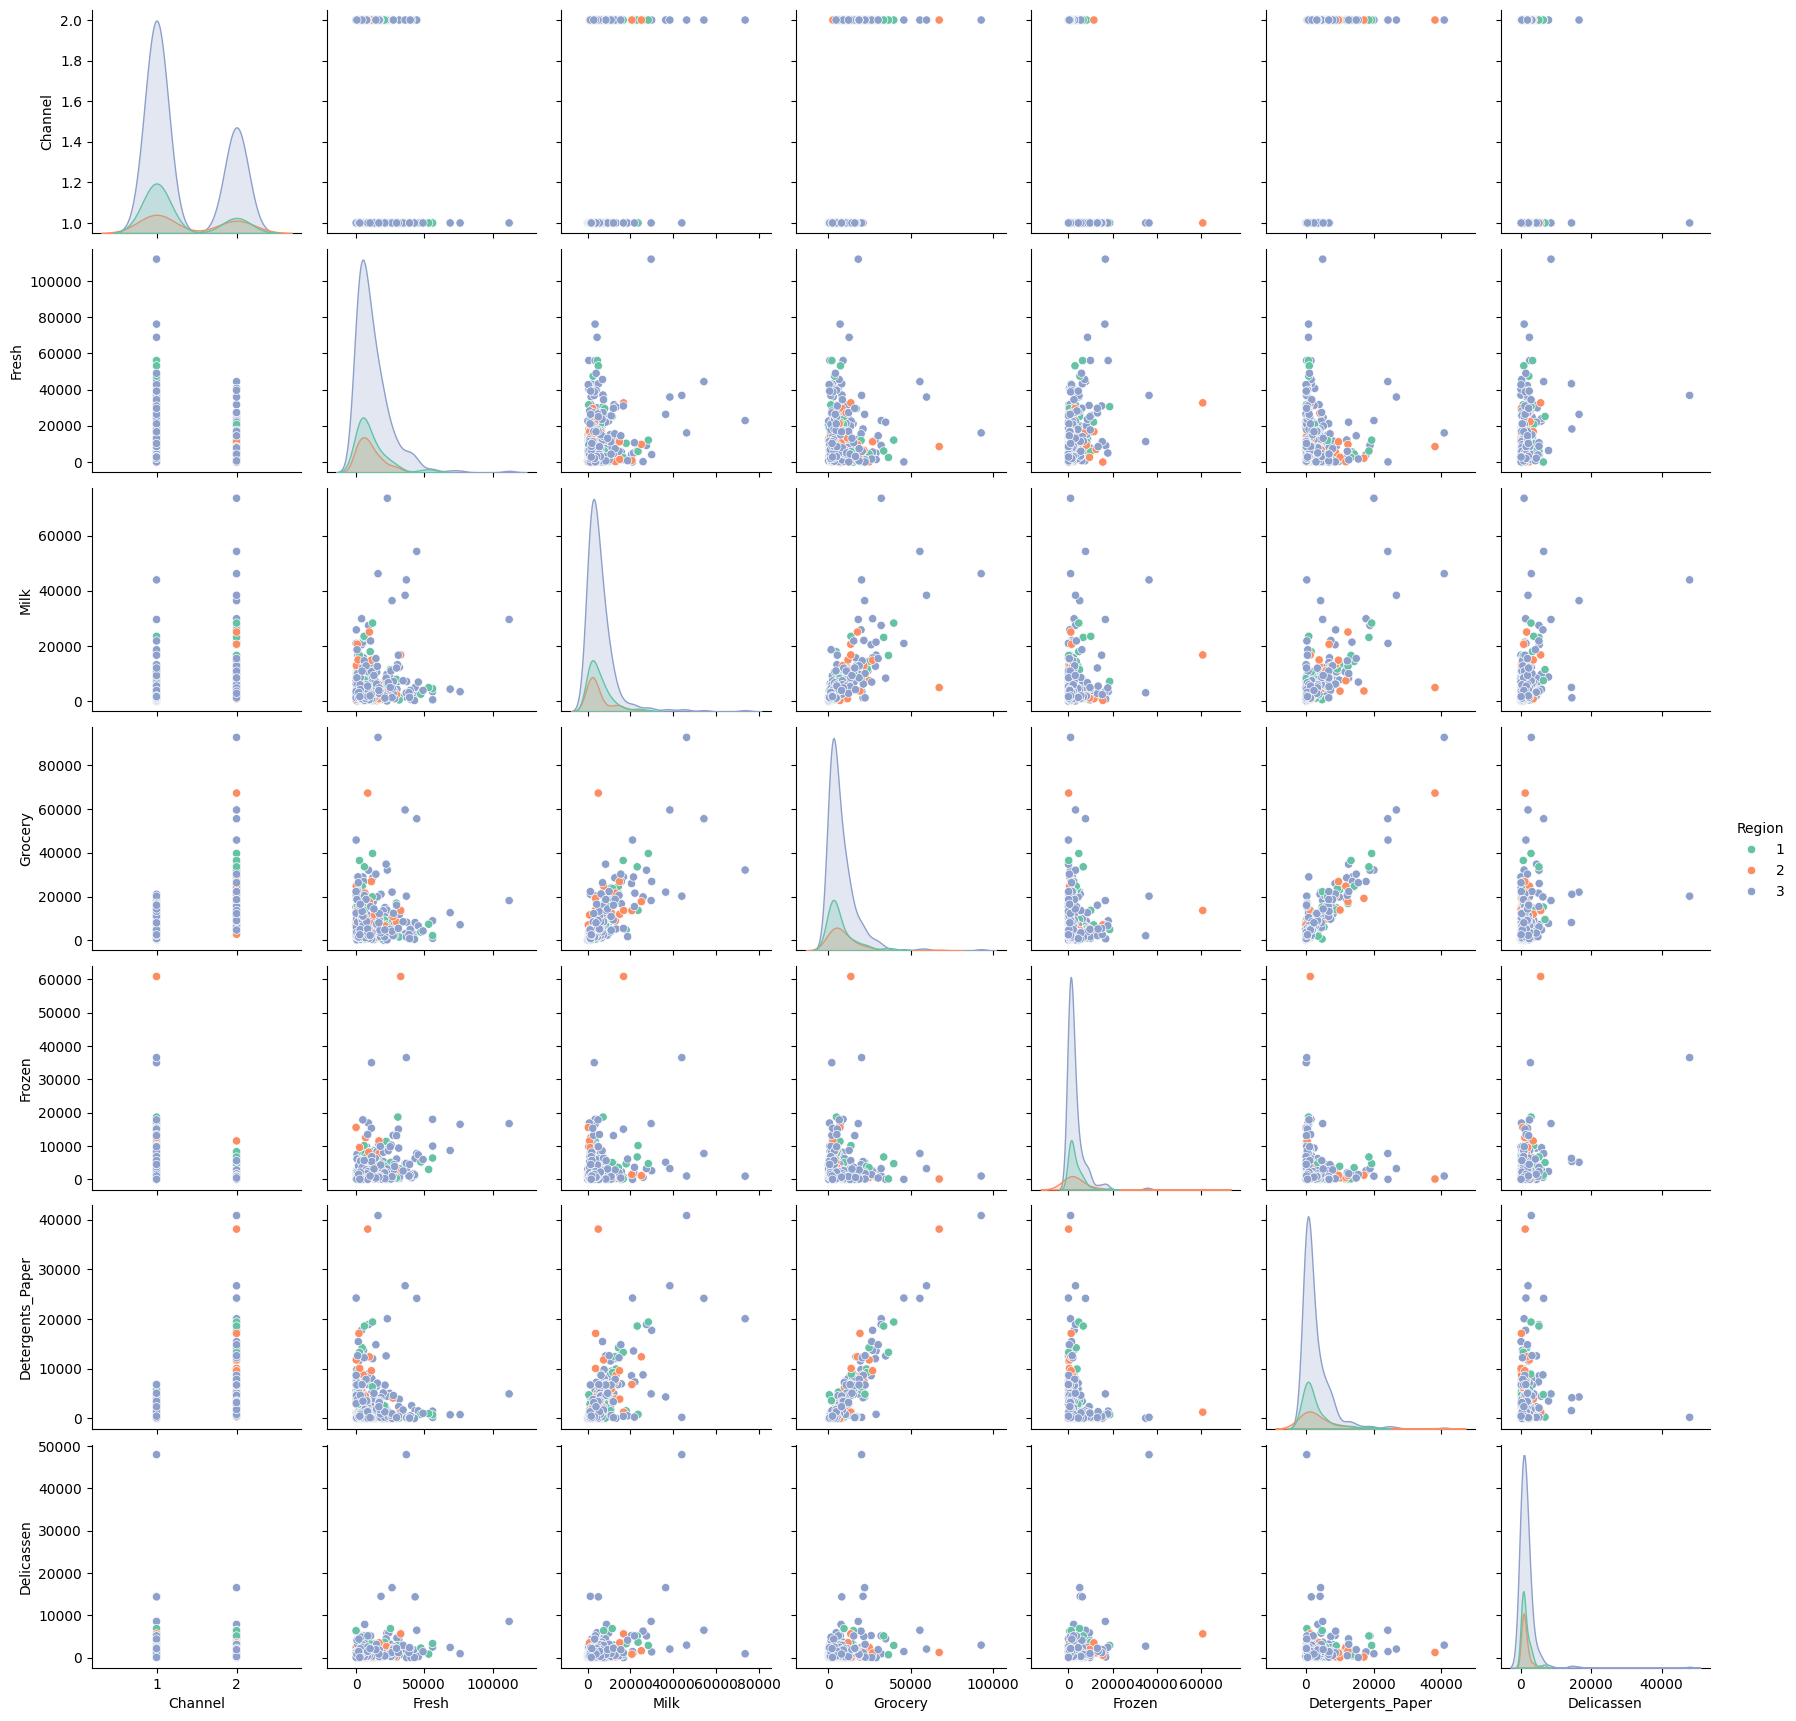

In [49]:
sns.pairplot(df,hue='Region',palette='Set2')

## DBSCAN

**TASK: Since the values of the features are in different orders of magnitude, let's scale the data. Use StandardScaler to scale the data.**

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

In [7]:
scaled_df = scaler.fit_transform(df) #we used df directly cuz there was nothing to drop (ex: pk or unique col)

In [60]:
scaled_df

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]], shape=(440, 8))

**TASK: Use DBSCAN and a for loop to create a variety of models testing different epsilon values. Set min_samples equal to 2 times the number of features. During the loop, keep track of and log the percentage of points that are outliers. For reference the solutions notebooks uses the following range of epsilon values for testing:**

    np.linspace(0.001,3,50)

In [8]:
from sklearn.cluster import DBSCAN

In [10]:
data_dim = df.shape[1] # if we've dropped some cols then we should use X.shape[1] instead
outliers_percent = []
outliers = [] # just to be safe if we needs it later
eps_list = np.linspace(0.001,3,50)

for i in eps_list:
    model = DBSCAN(eps=i,min_samples=2*data_dim,n_jobs=-1)
    model.fit(scaled_df) # could use .fit_predict on a var, or just .labels_ after fit, cuz it auto predict on the fitted data
    
    outliers.append(np.sum(model.labels_ == -1)) # we summed the trues. also np.sum is faster than normal sum()
    outliers_percent.append(100 * np.sum(model.labels_ == -1) / len(model.labels_)) # for the denominator (total) we dont have trues, we have clusters nums, so we'll use len()

**TASK: Create a line plot of the percentage of outlier points versus the epsilon value choice.**

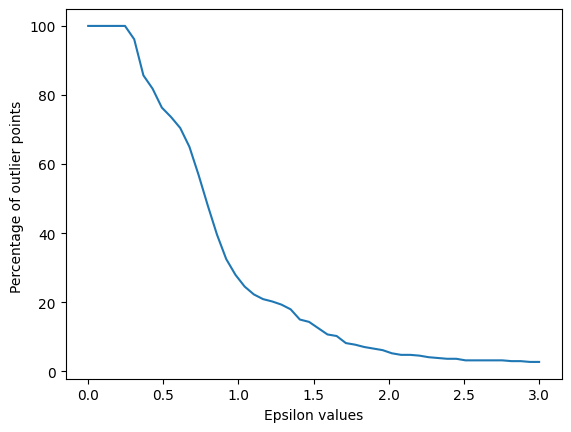

In [80]:
plt.plot(eps_list,outliers_percent)

plt.ylabel('Percentage of outlier points ')
plt.xlabel('Epsilon values');

## DBSCAN with Chosen Epsilon

**TASK: Based on the plot created in the previous task, retrain a DBSCAN model with a reasonable epsilon value. Note: For reference, the solutions use eps=2.**

''

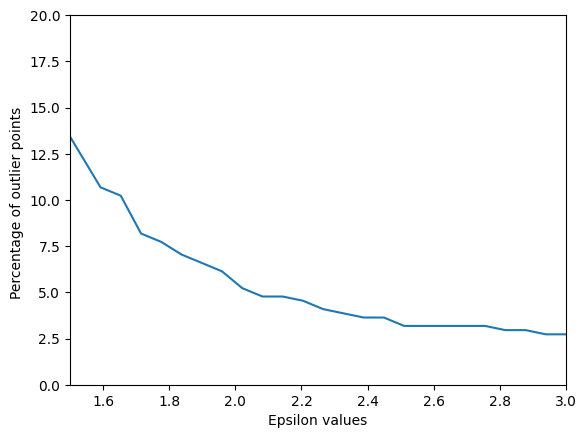

In [83]:
# to choose better, we'll zoom in that figure
plt.plot(eps_list,outliers_percent)

plt.ylabel('Percentage of outlier points ')
plt.xlabel('Epsilon values')

plt.xlim(1.5,3)
plt.ylim(0,20)
; # 2.0 - 2.3  we'll look into how many clusters they give

In [112]:
# 2.0 - 2.3  we'll look into how many clusters they give

for i in [2,2.1,2.2,2.3]:
    model = DBSCAN(eps=i,min_samples=2*data_dim)
    model.fit(scaled_df)
    
    print(len(set(model.labels_))) # num of clusters
    print(np.sum(model.labels_ == -1)) # num of outliers
    print("----------")

3
25
----------
3
21
----------
2
20
----------
2
17
----------


In [11]:
# 2.2 and 2.3 are bad, they didnt give much clusters, i'll choose 2.1

model = DBSCAN(eps=2.1,min_samples=2*data_dim)
model.fit(scaled_df)

,eps,2.1
,min_samples,16
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


**TASK: Create a scatterplot of Milk vs Grocery, colored by the discovered labels of the DBSCAN model.**

<Axes: xlabel='Grocery', ylabel='Milk'>

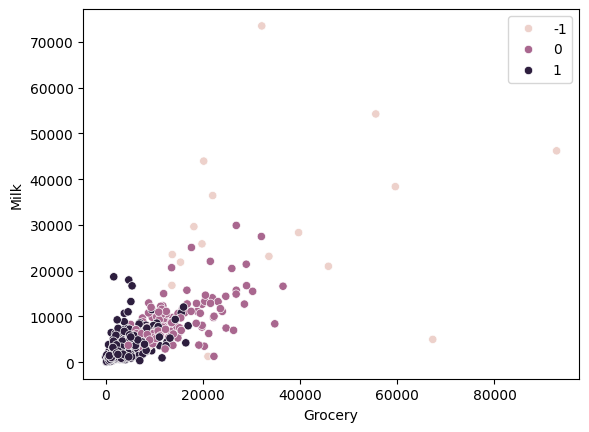

In [119]:
sns.scatterplot(df,x='Grocery',y='Milk',hue=model.labels_) # directly to hue, or we could just add col ['CLUSTER] to df then hue on it

**TASK: Create a scatterplot of Milk vs. Detergents Paper colored by the labels.**

<Axes: xlabel='Detergents_Paper', ylabel='Milk'>

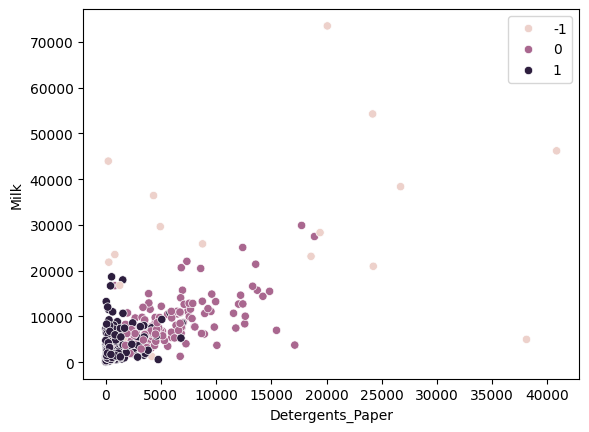

In [120]:
sns.scatterplot(df,x='Detergents_Paper',y='Milk',hue=model.labels_) 

<AxesSubplot:xlabel='Detergents_Paper', ylabel='Milk'>

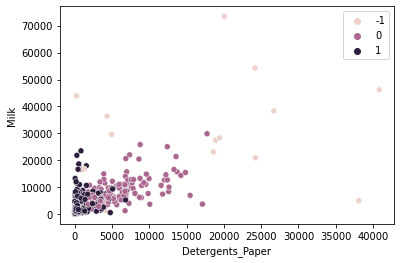

In [134]:
# their results looks like:

**TASK: Create a new column on the original dataframe called "Labels" consisting of the DBSCAN labels.**

In [12]:
df['Labels'] = model.labels_

In [13]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


**TASK: Compare the statistical mean of the clusters and outliers for the spending amounts on the categories.**

In [109]:
df

In [25]:
means = df.drop(['Channel','Region'],axis=1).groupby('Labels').mean()  # 'statistic mean' == no categories values
means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,30119.285714,24222.523810,28509.523810,11720.142857,11504.666667,7373.666667
0,8268.848485,8861.643939,14011.674242,1546.727273,6114.045455,1539.825758
1,12390.724739,3038.142857,3659.655052,3140.623693,763.780488,1090.031359


**TASK: Normalize the dataframe from the previous task using MinMaxScaler so the spending means go from 0-1 and create a heatmap of the values.**

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
mmscaler = MinMaxScaler()

In [27]:
normalized_means = mmscaler.fit_transform(means) # like we said, X always gets fit_transformed

In [31]:
means_df = pd.DataFrame(normalized_means,means.index,means.columns)
means_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
0,0.00000,0.274896,0.416582,0.000000,0.498121,0.071582
1,0.18864,0.000000,0.000000,0.156673,0.000000,0.000000


<Axes: ylabel='Labels'>

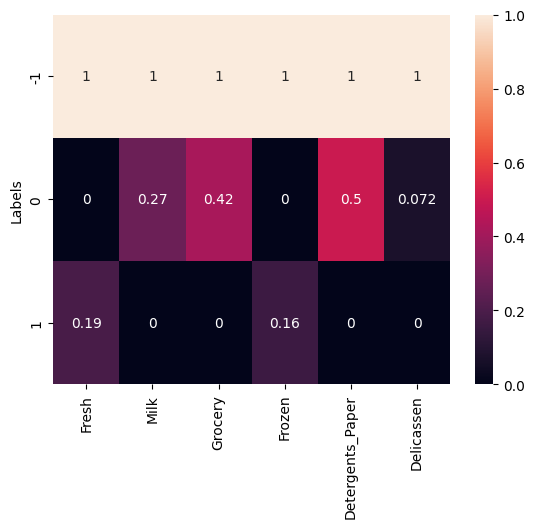

In [33]:
sns.heatmap(means_df,annot=True)

**TASK: Create another heatmap similar to the one above, but with the outliers removed**

<Axes: ylabel='Labels'>

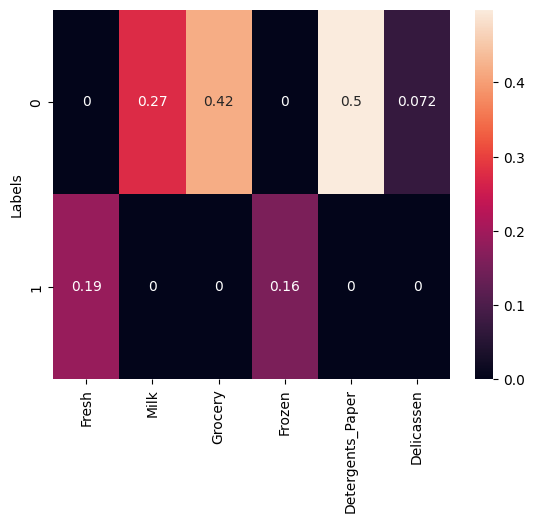

In [44]:
sns.heatmap(means_df.drop(-1),annot=True)  # or .drop(means_df.index[0])

**TASK: What spending category were the two clusters mode different in?**

In [126]:
# Detergents_paper

# FROM THIS INTERPRETATION: the clients of cluster 0 spent A LOT in detergents_paper compared to cluster 1, which makes it the feature that is MOST significant in adding clients to cluster 0. (grocery col is close to it too)